# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import skfda
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from scipy.integrate import simps
from adjustText import adjust_text

# Read Data

In [3]:
gait_df = pd.read_csv("gait.csv")
gait_df.head()

,subject,condition,replication,leg,joint,time,angle
0,1,1,1,1,1,0,4.682881
1,1,1,1,1,1,1,5.073127
2,1,1,1,1,1,2,5.229774
3,1,1,1,1,1,3,5.083273
4,1,1,1,1,1,4,4.652399


# Get foreground and background data

In [4]:
def extract_corrected_angle_series(df, condition, joint):
    # Filter the DataFrame for the specified condition and joint
    filtered_df = df[(df['condition'] == condition) & (df['joint'] == joint)]
    # Extract angle time series grouped by subject, replication, and leg
    series_list = filtered_df.groupby(['subject', 'replication', 'leg'])['angle'].apply(list).tolist()
    return series_list

# Apply the function for condition 1 and 3 with joint=2
background = extract_corrected_angle_series(gait_df, 1,2)
foreground = extract_corrected_angle_series(gait_df, 3,2)


def extract_legs_by_condition(df, condition, joint):
    filtered_df = df[(df['condition'] == condition) & (df['joint'] == joint)]
    legs = filtered_df.groupby(['subject', 'replication', 'leg'])['leg'].first().tolist()
    return legs

background_leg = extract_legs_by_condition(gait_df, 1, 2)
foreground_leg = extract_legs_by_condition(gait_df, 3, 2)





# Figure 5a

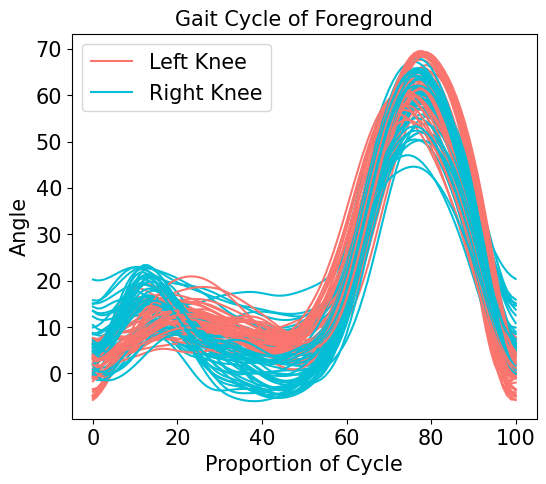

In [6]:
def plot_angle_series_by_leg(angle_series_list, legs, title="Angle Series by Leg"):
    # Colors for different legs
    leg_colors = {1: '#F9756E', 2: '#04BED5'}
    # Mapping for leg numbers to descriptions
    leg_descriptions = {1: 'Left Knee', 2: 'Right Knee'}
    
    plt.figure(figsize=(6, 5))
    
    added_legends = set()

    for series, leg in zip(angle_series_list[:100], legs[:100]):
        label = leg_descriptions[leg]
        if label not in added_legends:
            plt.plot(series, color=leg_colors[leg], label=label)
            added_legends.add(label)
        else:
            plt.plot(series, color=leg_colors[leg])
    
    plt.xlabel("Proportion of Cycle", fontsize = 15)
    plt.ylabel("Angle", fontsize = 15)
    plt.legend(fontsize = 15)
    plt.title(label = title, fontsize = 15)
    plt.tick_params(axis='x', labelsize=15)  
    plt.tick_params(axis='y', labelsize=15)  

    plt.show()

plot_angle_series_by_leg(foreground, foreground_leg, "Gait Cycle of Foreground")


# Figure 5b

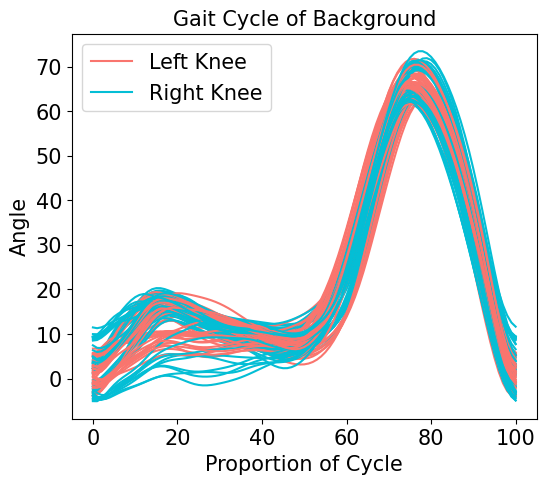

In [7]:
plot_angle_series_by_leg(background, background_leg, "Gait Cycle of Background")


In [8]:
def center_time_series(data_list):
    data_array = np.array(data_list)
    means = np.mean(data_array, axis=0)
    centered_data = (data_array - means) 
    centered_data = centered_data.tolist()

    return centered_data


standardized_brace_list = center_time_series(foreground)
standardized_normal_list = center_time_series(background)

# Figure 5c

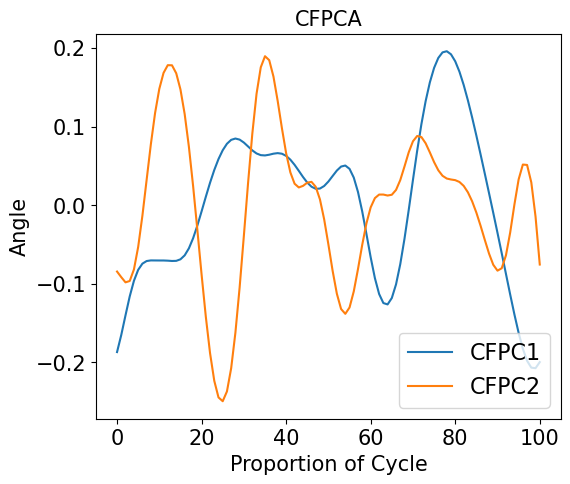

In [16]:
import os
os.chdir('..')
from main import *

t = np.linspace(0, 100, 101)

components = CFPCA(standardized_brace_list,standardized_normal_list,5,t,True,True)[0]
fpca_foreground = CFPCA(standardized_brace_list,standardized_normal_list,0,t, True, True)[0]
fpca_foreground_background = CFPCA(standardized_brace_list+standardized_normal_list,standardized_normal_list,0,t, True, True)[0]


plt.figure(figsize=(6, 5))
plt.xlabel("Proportion of Cycle", fontsize = 15)
plt.ylabel("Angle", fontsize = 15)
plt.plot(t, components[:,0])
plt.plot(t, components[:,1])
plt.legend(['CFPC1', 'CFPC2'], fontsize = 16, loc = 'lower right')
plt.title("CFPCA", fontsize = 15)
plt.tick_params(axis='x', labelsize=15)  
plt.tick_params(axis='y', labelsize=15)  

In [17]:
def calculate_scores(data_lists, eigenvector):
    """
    Calculate the PC scores for each time series represented by a list in data_lists.
    
    Parameters:
    - data_lists: List of lists, each inner list is a time series for a company.
    - eigenvector: The eigenvector to use for calculating PC scores.
    - t: The time array over which to integrate.
    
    Returns:
    - A numpy array with PC scores for each time series.
    """
    # Convert data lists to a numpy array for efficient computation
    data_array = np.array(data_lists)
    
    # Calculate the integral using the trapezoidal rule for each time series
    pc_scores = np.array([simps(data_array[i] * np.real(eigenvector), dx = 1) for i in range(data_array.shape[0])])
    return pc_scores


unique_pc_score1 = calculate_scores(standardized_brace_list, components[:,0])
unique_pc_score2 = calculate_scores(standardized_brace_list, components[:,1])

fpc_1_foreground = calculate_scores(standardized_brace_list, fpca_foreground[:,0])
fpc_2_foreground = calculate_scores(standardized_brace_list, fpca_foreground[:,1])

fpc_1_foreground_background = calculate_scores(standardized_brace_list, fpca_foreground_background[:,0])
fpc_2_foreground_background = calculate_scores(standardized_brace_list, fpca_foreground_background[:,1])


In [23]:
def plot_pc_scores(pc_scores1, pc_scores2, legs,title):
    plt.figure(figsize=(6, 5))  # Adjusted for better visibility of labels and colors
    texts = []  # List to store all the text objects for adjust_text
    colors = ['#F9756E' if leg == 1 else '#04BED5' for leg in legs]  # Assuming 1 for left and 2 for right, adjust as necessary
    
    
    # Plot each point, now colored by leg
    for i in range(len(pc_scores1)):
        plt.scatter(pc_scores1[i], pc_scores2[i], color=colors[i])  # Color by leg
    

    plt.title(title ,fontsize = 17)
    
    # Legend
    plt.scatter([], [], color='#F9756E', label='Left Knee')
    plt.scatter([], [], color='#04BED5', label='Right Knee')
    plt.legend(fontsize = 15, loc = "upper right")
    
    # Use adjust_text to minimize text overlaps
    plt.tick_params(axis='x', labelsize=15)  
    plt.tick_params(axis='y', labelsize=15)  




# Figure 4a

In [ ]:
plot_pc_scores(fpc_1_foreground, fpc_2_foreground, foreground_leg, "FPCA on Foreground")
plt.xlabel('FPC 1', fontsize = 17)
plt.ylabel('FPC 2', fontsize = 17)

X = np.column_stack((fpc_1_foreground, fpc_2_foreground))

# Calculate Silhouette Score
sil_score = silhouette_score(X, foreground_leg)
print("Silhouette Score:", sil_score)

# Calculate Davies-Bouldin Score
db_score = davies_bouldin_score(X, foreground_leg)
print("Davies-Bouldin Score:", db_score)

# Figure 4b

Silhouette Score: 0.027697390605321434
Davies-Bouldin Score: 5.7147422430619494


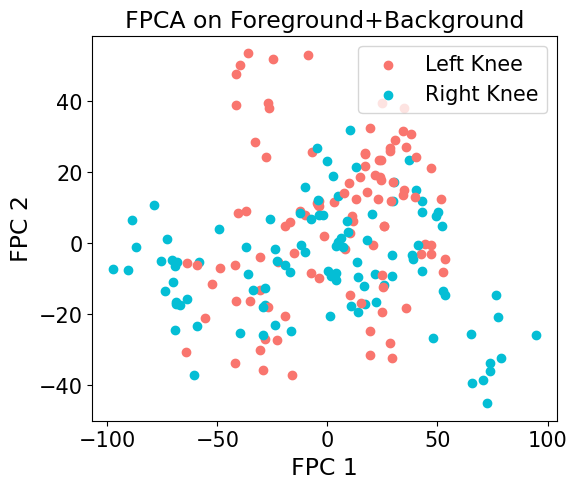

In [37]:
plot_pc_scores(fpc_1_foreground_background, fpc_2_foreground_background, foreground_leg, "FPCA on Foreground+Background")
plt.xlabel('FPC 1', fontsize = 17)
plt.ylabel('FPC 2', fontsize = 17)

X = np.column_stack((fpc_1_foreground_background, fpc_2_foreground_background))

# Calculate Silhouette Score
sil_score = silhouette_score(X, foreground_leg)
print("Silhouette Score:", sil_score)

# Calculate Davies-Bouldin Score
db_score = davies_bouldin_score(X, foreground_leg)
print("Davies-Bouldin Score:", db_score)

# Figure 4c

Silhouette Score: 0.5131899350705504
Davies-Bouldin Score: 0.6554717928232753


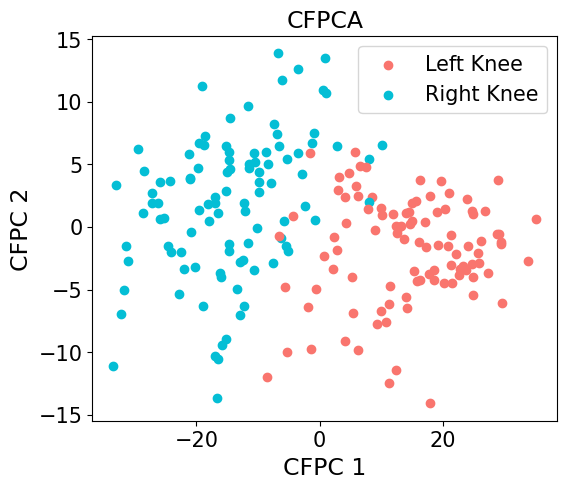

In [38]:
plot_pc_scores(unique_pc_score1, unique_pc_score2, foreground_leg, "CFPCA")
plt.xlabel('CFPC 1', fontsize = 17)
plt.ylabel('CFPC 2', fontsize = 17)

X = np.column_stack((unique_pc_score1, unique_pc_score2))

# Calculate Silhouette Score
sil_score = silhouette_score(X, foreground_leg)
print("Silhouette Score:", sil_score)

# Calculate Davies-Bouldin Score
db_score = davies_bouldin_score(X, foreground_leg)
print("Davies-Bouldin Score:", db_score)

# Appendix - Figure 13a

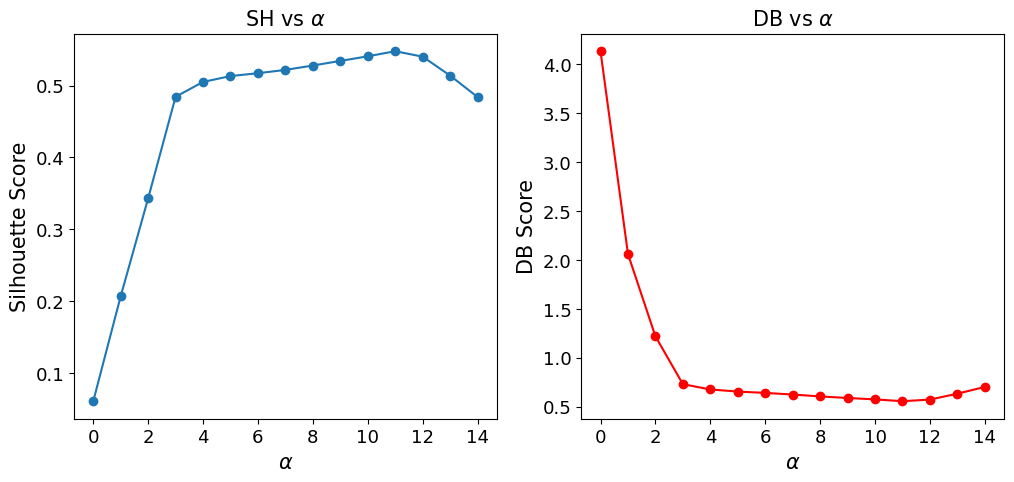

In [41]:
# Function to compute FPCA components given foreground, background, and alpha
def compute_and_plot_components(foreground, background, alpha):
    components = CFPCA(foreground,background, alpha, t, True, True)[0]

    unique_pc_score1 = calculate_scores(foreground, components[:,0])
    unique_pc_score2 = calculate_scores(foreground, components[:,1])
    X = np.column_stack((unique_pc_score1, unique_pc_score2))

    return X

alphas = range(0, 15)
silhouette_scores = []
db_scores = []

for alpha in alphas:
    X = compute_and_plot_components(standardized_brace_list, standardized_normal_list, alpha)
    silhouette_avg = silhouette_score(X, foreground_leg)
    db_avg = davies_bouldin_score(X, foreground_leg)
    
    silhouette_scores.append(silhouette_avg)
    db_scores.append(db_avg)

# Plotting the silhouette and DB scores
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(alphas, silhouette_scores, marker='o', linestyle='-')
plt.title(r'SH vs $\alpha$', fontsize = 15)
plt.xlabel(r'$\alpha$', fontsize = 15)
plt.ylabel('Silhouette Score', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.subplot(1, 2, 2)
plt.plot(alphas, db_scores, marker='o', linestyle='-', color='r')
plt.title(r'DB vs $\alpha$', fontsize = 15)
plt.xlabel(r'$\alpha$', fontsize = 15)
plt.ylabel('DB Score', fontsize = 15)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)

plt.show();